# Notebook to identify the neural invariance manifold with a CPPN mapping from a latent space

* neuron invariance: identity (simple cell)
* latent space topology: sheet (bounded non periodic 2D)

---

### Imports and config parameters



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
from classicalv1.toy_models import RotationInvariantGabor, RotationInvariantComplex, ComplexCell
from invariance_generation.datamodule import JitteringGridDatamodule
from invariance_generation.cppn import CPPNForInvariances
from invariance_generation.regularization import SimCLROnGrid
from invariance_generation.utils.plot_utils import plot_f, plot_filters
import os
import math
from PIL import Image
import glob
import matplotlib


font = {'size'   : 20}
matplotlib.rc('font', **font)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with_periodic_invariances = False 
temperature =  1
grid_points_per_dim = 20
num_invariances=2
reg_coefs = [1, 0.5]
epochs_per_reg = 100
lr = 1e-2
random_seed = 41
np.random.seed(random_seed)
torch.manual_seed(random_seed)


### Initialize the neuron model
This Gabor based neuron is implemented as a simple cell

In [2]:
neuron_config = {
    "res": [30, 30],
    "n_thetas": 1,
    "pos": [0, 0],
    "max_angle": 2 * np.pi,
}
encoding_model = RotationInvariantGabor(**neuron_config).to(device)

### Initialize CPPN

The CPPN is an MLP that create images depending on an input parameter z (latent) predicting pixel values from x and y coordinates

In [3]:
cppn_config = dict(    
    img_res=[30,30],
    channels=1,
    positional_encoding_dim=10,
    positional_encoding_projection_scale=1.,
    num_neurons=1,
    num_invariances=num_invariances,
    with_periodic_invariances=with_periodic_invariances,
    nonlinearity=nn.LeakyReLU,
    weights_scale=.1,
    batchnorm=True,
    bias=True,
    aux_dim_scale=1.
)
cppn = CPPNForInvariances(**cppn_config).to(device)

### Intermediate image transformation 

fix mean and standard deviation (luminance and contrast) before passing images to the neural response model

In [4]:
class FixMeanStd(nn.Module):
    def __init__(self, mean=None, std=None, eps=1e-12):
        super().__init__()
        self.mean = mean
        self.std = std
        self.eps = eps
    def forward(self, img):
        if self.mean is not None:
            img_mean = img.mean(dim=(2, 3), keepdim=True)
            img1 = self.mean + img - img_mean
        else:
            img1 = img
        if self.std is not None:        
            img_std = img1.std(dim=(2, 3), keepdim=True)
            img2 = self.std * img1 / (img_std + self.eps)
        return img2

img_trans_config = dict(mean=0, std=.2)
img_transforms = FixMeanStd(**img_trans_config).to(device)

### Dataloader to load latent grid 

This "datamodule" sample the grid of points in the latent space from which to create images at each training step. 

In [5]:
dataloader_config = dict(
    num_invariances=num_invariances,
    grid_points_per_dim=grid_points_per_dim, 
    steps_per_epoch=100, 
)
dm = JitteringGridDatamodule(**dataloader_config)
dm.train_dataloader()
grid = dm.grid.to(device)


### Constrastive learning objective module

This object define positive and negative points for each point in the grid and changes depending on latent space topology. 

We plot the neighbouring mask of a point in the uppermost corner of the sheet to check periodic conditions

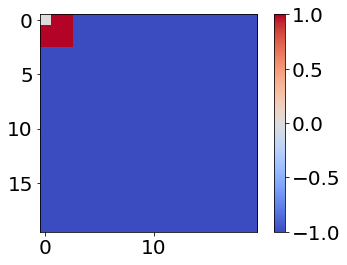

In [6]:
objective_config = dict(
    num_invariances=num_invariances,
    grid_points_per_dim=grid_points_per_dim,
    neighbor_size=.1,
    temperature = temperature,
    with_periodic_invariances=with_periodic_invariances,
    with_round_neighbor = False
)

grid_reg = SimCLROnGrid(**objective_config).to(device)
plot_f(grid_reg.neighbor_mask[0,0])

### Create a forward function 

It feeds point to CPPN to create images, fixes their luminance and contrast and pass them to the neural model to get activations

In [7]:
def forward(grid, cppn, img_tranfs, encoding_model, resolution_increase_factor=1.):
    """forward pass throught the pipeline """
    img_pre = cppn(grid)
    img_post = img_tranfs(img_pre)
    acts = encoding_model(img_post)
    
    if resolution_increase_factor > 1:
        with torch.no_grad():
            img_pre_hres = cppn(grid, img_res=[r*resolution_increase_factor for r in cppn.img_res])
            img_post_hres = img_transforms(img_pre_hres)       
    else:
        img_post_hres = img_post
    
    return img_pre, img_post, acts, img_post_hres

### Get neuron MEI activation

MEI (maximally exciting image) activation can be obtained via direct pixel optimization to maximase neural response (no contrastive loss). 

In [8]:
MEI_activation = 32.566429138183594 #  contrast dependent!

## Train the generative model 

The cppn is trained to maximaxe activation and produce different images with a constrastive regularization term with a regularization strength decreasing schedule

In [10]:
for reg_idx, reg_scale in enumerate(reg_coefs):
    num_epochs = epochs_per_reg
    optimizer = torch.optim.Adam(cppn.parameters(), lr=lr)
    pbar = tqdm(range(num_epochs), desc='mean activation will appear after one epoch')
    encoding_model.eval()
    for epoch in pbar:
        # Training
        cppn.train()
        for input_grid in dm.train_dataloader():
            input_grid = input_grid.to(device)
            img_pre, img_post, _acts, _ = forward(input_grid, cppn, img_transforms, encoding_model)
            acts = _acts/MEI_activation
            loss = -acts.mean() - reg_scale * grid_reg.reg_term(img_post)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f"Act = {acts.mean().item():.2f} | Reg ({reg_idx+1}/{len(reg_coefs)}) = {reg_scale}")

Act = 1.00 | Reg (1/2) = 1: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]       
Act = 1.01 | Reg (2/2) = 0.5: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]     


## Plots results

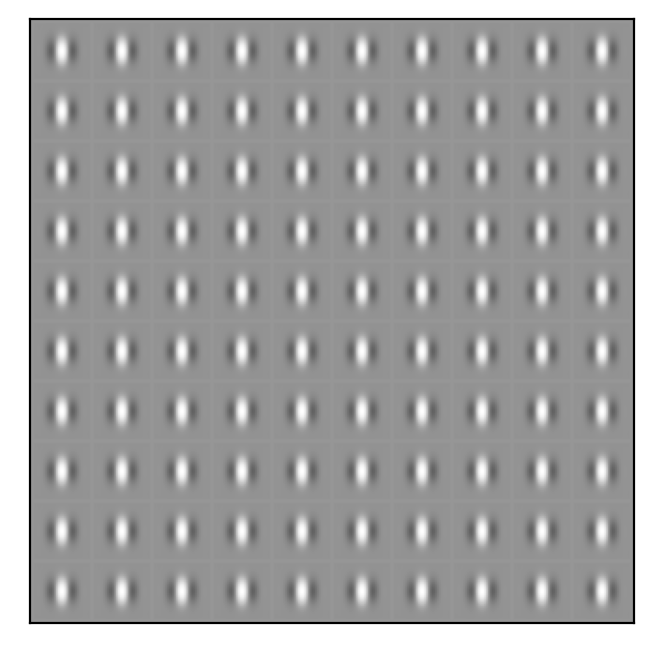

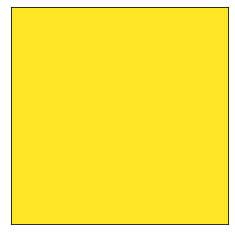

In [11]:
cell = 'simple_cell'
# datamodule useful for visualization purposes
_dm = JitteringGridDatamodule(
    num_invariances=dataloader_config["num_invariances"],
    grid_points_per_dim=10,
    steps_per_epoch=dataloader_config["steps_per_epoch"],
)
grid_vis = _dm.grid.to(device)
img_pre, img_post, _acts, _ = forward(grid_vis, cppn, img_transforms, encoding_model)

fig, ax = plot_filters(
    img_post, nrow=int(np.sqrt(grid_vis.shape[0])), cmap="Greys_r"
)
ax.set(xticks=[], yticks=[])
folder = f"/project/plots/2D/sheet/{cell}/temp_{temperature}"
os.makedirs(folder, exist_ok=True)
name = folder + 'grid_img.png'
plt.savefig(name, bbox_inches="tight", transparent=True)

dataloader_config = dict(
    num_invariances=2,
    grid_points_per_dim=100,
    steps_per_epoch=100,
)
_dm = JitteringGridDatamodule(**dataloader_config)
_dm.train_dataloader()
grid = _dm.grid.to(device)
with torch.no_grad():
    img_pre, img_post, _acts, _ = forward(
        grid,
        cppn,
        img_transforms,
        encoding_model,
        resolution_increase_factor=3,
    )
    act = _acts / MEI_activation

fig, ax = plt.subplots(1, 1)
im = ax.imshow(
    act.reshape(100, 100).detach().cpu().numpy(),
    vmin=0,
    vmax=1,
    extent=[0, 2 * np.pi] * 2,
)

ax.set(xticks=[], yticks=[])
name = folder + 'activity.png'
plt.savefig(name, bbox_inches="tight", transparent=True)
